# Convert Postgres Data to Zips

This notebook is a copy of the one in `20200204_zips_for_teps`. It hacks `traffic_prophet` to convert the 15-minute bin volume data table `czhu.btp_centreline_volumes` into zip files of text files organized by centreline ID, direction and year.

Each text file is tab-delimited with the columns:

```
nonsense	centreline_id	dir_bin	count_bin	volume	count_type
1921:43951732	8237152	-1	28-Jan-2016 00:00:00	50	1
1922:43951733	8237152	-1	28-Jan-2016 00:15:00	33	1
...
```

In [1]:
%matplotlib inline
import sys
sys.path.append('./bdit_traffic_prophet/')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd
import zipfile
import warnings
import psycopg2
import contextily as cx

import pandas as pd
import geopandas as gpd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_volumes')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    raise ValueError
    
postgres_settings = config['POSTGRES']
postgres_settings['dbname'] = 'bigdata'

In [2]:
from traffic_prophet.countmatch import reader

In [3]:
# Get HW401 centreline IDs
zipsn = ["../../VolumeModel/TEPS-I-EEDrun/PRTCS/negative/15min_counts_{0}.zip".format(x)
         for x in range(2006, 2017)]
zipsp = ["../../VolumeModel/TEPS-I-EEDrun/PRTCS/positive/15min_counts_{0}.zip".format(x)
         for x in range(2006, 2017)]
zips = zipsn + zipsp
rdr = reader.ReaderZip(zips)

re_centrelines = []

for zf in rdr.source:
    for c in rdr.get_zipreader(zf):
        if 're' in c['filename']:
            re_centrelines.append([c['filename'], c['centreline_id']])

re_centreline_ids = list(set([x[1] for x in re_centrelines]))

In [4]:
# Get all centreline IDs in mid_f_point.csv
df = pd.read_csv("../../VolumeModel/TEPS-I-EEDrun/PRTCS/negative/mid_f_point.csv", header=None)
midpoint_centerline_ids = list(df[0].values)

In [5]:
# Get all centreline IDs in Landuse_pop_lane_speed.xlsx
df = pd.read_excel("../../VolumeModel/TEPS-I-EEDrun/PRTCS/negative/locals/Landuse_pop_lane_speed.xlsx")
landuse_centreline_ids = list(df['centreline'].values)

In [6]:
available_teps_centreline_ids = list(
    set(midpoint_centerline_ids).intersection(set(landuse_centreline_ids)))

Problem: `prj_volume.centreline_volumes` contains both ATR and TMC counts - the former is `count_type = 1` and the latter `2`. TMC counts aren't 24 hour counts, and neither Traffic Prophet nor TEPs have controls that ensure they're rejected by the count matching algorithm. We should remove them from the zip-making procedure.

Trouble is they were included back in March for the 2017 and 2018 zips, so we'll have to regenerate those too.

In [7]:
class ReaderPostgresRaw(reader.ReaderBase):
    """Hacked method of accessing the raw 15-minute bin table from Postgres.
    
    Only includes ATR counts (`count_type = 1`).
    """

    def get_pgreader(self, year):
        with self.source.connect() as db_con:
            sql_cmd = (
                ("SELECT centreline_id, dir_bin, count_bin, volume, count_type "
                 "FROM {dbt} WHERE EXTRACT(year from count_bin) = {year} AND count_type = 1"
                 "ORDER BY centreline_id, dir_bin, count_bin")
                .format(dbt=self.source.tablename,  year=year))

            all_data = pd.read_sql(sql_cmd, db_con,
                                   parse_dates=['count_bin', ])

            for key, df in all_data.groupby(['centreline_id', 'dir_bin']):
                centreline_id = key[0]
                direction = key[1]

                data = df[['count_bin', 'volume', 'count_type']].copy()
                data.columns = ['Timestamp', '15-minute Volume', 'Count Type']
                data.reset_index(drop=True, inplace=True)

                # Filename is used to flag for HW401 data in Arman's zip files,
                # so just pass a dummy value here.  Note that we can't use
                # 'postgres' here since it contains 're'!
                yield {'filename': 'fromPG',
                       'centreline_id': int(centreline_id),
                       'direction': int(direction),
                       'data': data,
                       'year': year}

    def write_db_to_zip(self, year, fpath="./"):
        """Writes a year's worth of 15 minute bins"""
        rdr = self.get_pgreader(year)

        fhzp = zipfile.ZipFile(
            fpath + "15min_counts_{0}_positive.zip".format(year), 'w')
        fhzn = zipfile.ZipFile(
            fpath + "15min_counts_{0}_negative.zip".format(year), 'w')

        for tc in rdr:
            # Control sequence to prevent centreline_ids on HW401 and those with
            # no land use data from being included in zip.
            if tc['centreline_id'] in re_centreline_ids:
                warnings.warn("{0} found in HW401 IDs!".format(tc['centreline_id']))
                continue
            elif tc['centreline_id'] not in available_teps_centreline_ids:
                warnings.warn("{0} doesn't have TEPs land use/geographic data!".format(tc['centreline_id']))
                continue

            # Extract data from dict and convert it to TEPs format.
            data = tc['data']
            # Convert to DD-MMM-YYYY TT:TT:TT format favoured by Matlab.
            data['Timestamp'] = data['Timestamp'].dt.strftime(r"%d-%b-%Y %T")
            data['Nonsense'] = '999:9999999'
            data['Centreline ID'] = tc['centreline_id']
            data['Direction'] = tc['direction']
            # Output to csv, but dump to string instead of file.
            datastr = data[['Nonsense', 'Centreline ID', 'Direction',
                            'Timestamp', '15-minute Volume', 'Count Type']].to_csv(
                None, sep='\t', na_rep='N/A', header=False, index=False)

#             if tc['centreline_id'] in re_centreline_ids:
#                 filename = "{0}_99999_{1}.txt".format(tc['centreline_id'], year)
#             else:
#                 filename = "{0}_99999_{1}.txt".format(tc['centreline_id'], year)
            filename = "{0}_99999_{1}.txt".format(tc['centreline_id'], year)
            if tc['direction'] > 0:
                fhzp.writestr(filename, datastr)
            else:
                fhzn.writestr(filename, datastr)

In [8]:
pgreader = ReaderPostgresRaw(vol_conn)

In [9]:
pgreader.write_db_to_zip(2017)

In [10]:
pgreader.write_db_to_zip(2018)

In [11]:
pgreader.write_db_to_zip(2019)

Got a `/home/czhu/pipenv/bditto/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: 439727 found in HW401 IDs!` warning, but as it turns out, 439727 actually is OUR centreline label for an offramp of 401:

In [12]:
with psycopg2.connect(**postgres_settings) as conn:
    df_hw401 = gpd.read_postgis("""SELECT * FROM gis.centreline WHERE geo_id = 439727""", con=conn)

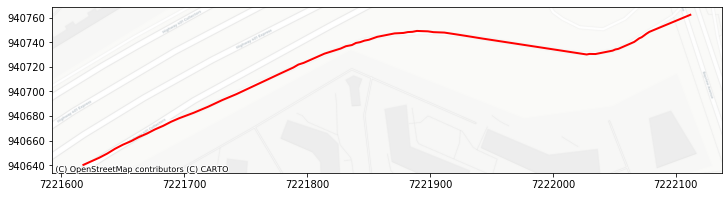

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
df_hw401.to_crs("epsg:3347", inplace=True)
df_hw401.plot(ax=ax, lw=2, color='r')
cx.add_basemap(ax, crs=df_hw401.crs, source=cx.providers.CartoDB.Positron)

Does that mean every segment in `re_centreline_ids` is a part of the HW400 system in `gis.centreline`?

In [16]:
query = """SELECT * FROM gis.centreline WHERE geo_id IN {0}"""

with psycopg2.connect(**postgres_settings) as conn:
    df_all_re_segments = gpd.read_postgis(query.format(tuple(re_centreline_ids)), con=conn)

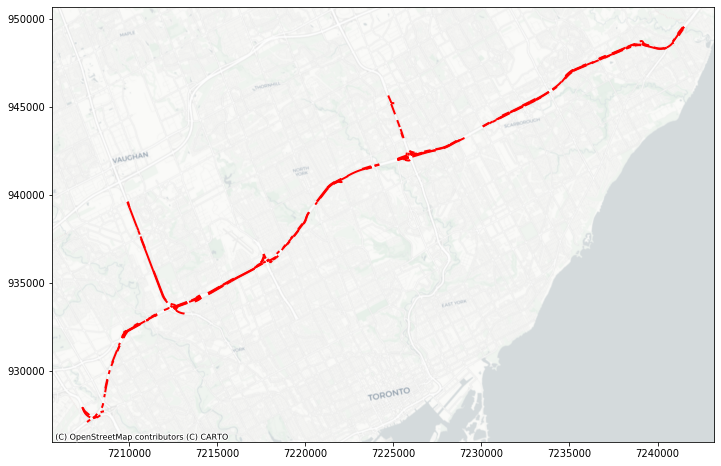

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
df_all_re_segments.to_crs("epsg:3347", inplace=True)
df_all_re_segments.plot(ax=ax, lw=2, color='r')
cx.add_basemap(ax, crs=df_all_re_segments.crs, source=cx.providers.CartoDB.Positron)

Yes, as it seems! I suppose we should have left that data in the zip file, but I don't think it really matters in the end.

Checking that the 2019 data looks okay:

In [18]:
def check_year(year):
    """Checks that zip file contents are identical to data from Postgres.
    
    If a count is missing from the read-in zips, or the data differs, prompts
    the user to check the raw data.
    """
    rdr_zn = reader.ReaderZip("dummy").get_zipreader("./15min_counts_{yr}_negative.zip".format(yr=year))
    rdr_zp = reader.ReaderZip("dummy").get_zipreader("./15min_counts_{yr}_positive.zip".format(yr=year))
    rdr_pg = ReaderPostgresRaw(vol_conn).get_pgreader(year)

    dzn = dict([(x['direction'] * x['centreline_id'], x['data']) for x in rdr_zn])
    dzp = dict([(x['direction'] * x['centreline_id'], x['data']) for x in rdr_zp])
    dpg = dict([(x['direction'] * x['centreline_id'], x['data']) for x in rdr_pg])

    for key in dpg.keys():
        cdz = dzn if key < 0 else dzp
        if key not in cdz.keys():
            print("Check ", key)
            continue
        cdz[key].columns = ['Timestamp', '15-minute Volume']
        if not dpg[key][['Timestamp', '15-minute Volume']].equals(cdz[key]):
            print("Check ", key)
            continue

In [19]:
check_year(2017)

Check  -20145295
Check  20145295


20145295 is in the zip files, but has less than 1 full day of data in either zip.

In [20]:
check_year(2018)

In [21]:
check_year(2019)

The other years look good. We're ready to run TEPs.